In [7]:
%config IPCompleter.greedy=True
%matplotlib notebook
import libs.lib as lib
lib.setup_logger('info', logfile='/home/adams/apertif/BP/8030111_3C286_0.log')
import apercal

import bp

root - INFO : Logging started!
root - INFO : Logging started!
root - INFO : To see the log in a bash window use the following command:
root - INFO : To see the log in a bash window use the following command:
root - INFO : tail -n +1 -f /home/adams/ipython-notebooks/commissioning/01/logs/8030111_3C286_0.log
root - INFO : tail -n +1 -f /home/adams/ipython-notebooks/commissioning/01/logs/8030111_3C286_0.log


Below is where the bandpass stability is explored; above is where the basic data preparation is undertaken

In [6]:
#This step should only need to be done once - this does the calibration and can take a few minutes
#The only reason to redo is if a different time interval is desired, or the data has been reflagged

cfgfile='/home/adams/apertif/BP/8030111_3C286_0.cfg'
inttime='30'
bp.do_bp(cfgfile,inttime='30')

CROSSCAL - INFO : ### Configuration file /home/adams/ipython-notebooks/commissioning/01/cfg/8030111_3C286_0.cfg successfully read! ###
CROSSCAL - INFO : # Moved to directory /data/adams/apertif/busydays/bp_rc_after/00/crosscal #


3C286.mir
calibration finished


In [8]:
#This reads the bandpass solutions derived above
#Unless the bp solution has been changed above, this doesn't need to be redone within a python session

#However, this reads the solutions into a numpy array in the active python session
#And so must be redone everytime the kernel is restarted.

cfgfile='/home/adams/ipython-notebooks/commissioning/01/cfg/8030111_3C286_0.cfg'
values, freqs = bp.get_bpsols(cfgfile)


print values.shape,freqs.shape

CROSSCAL - INFO : ### Configuration file /home/adams/ipython-notebooks/commissioning/01/cfg/8030111_3C286_0.cfg successfully read! ###
CROSSCAL - INFO : ### Configuration file /home/adams/ipython-notebooks/commissioning/01/cfg/8030111_3C286_0.cfg successfully read! ###


read calibration solutions into numpy array
(11, 11008, 24) (11008,)


In [9]:
#define the telescope names
#this is used generally throughout the notebook
tnames = ('RT2','RT3','RT4','RT5','RT6','RT7','RT8','RT9','RTA','RTB','RTC')

<IPython.core.display.Javascript object>


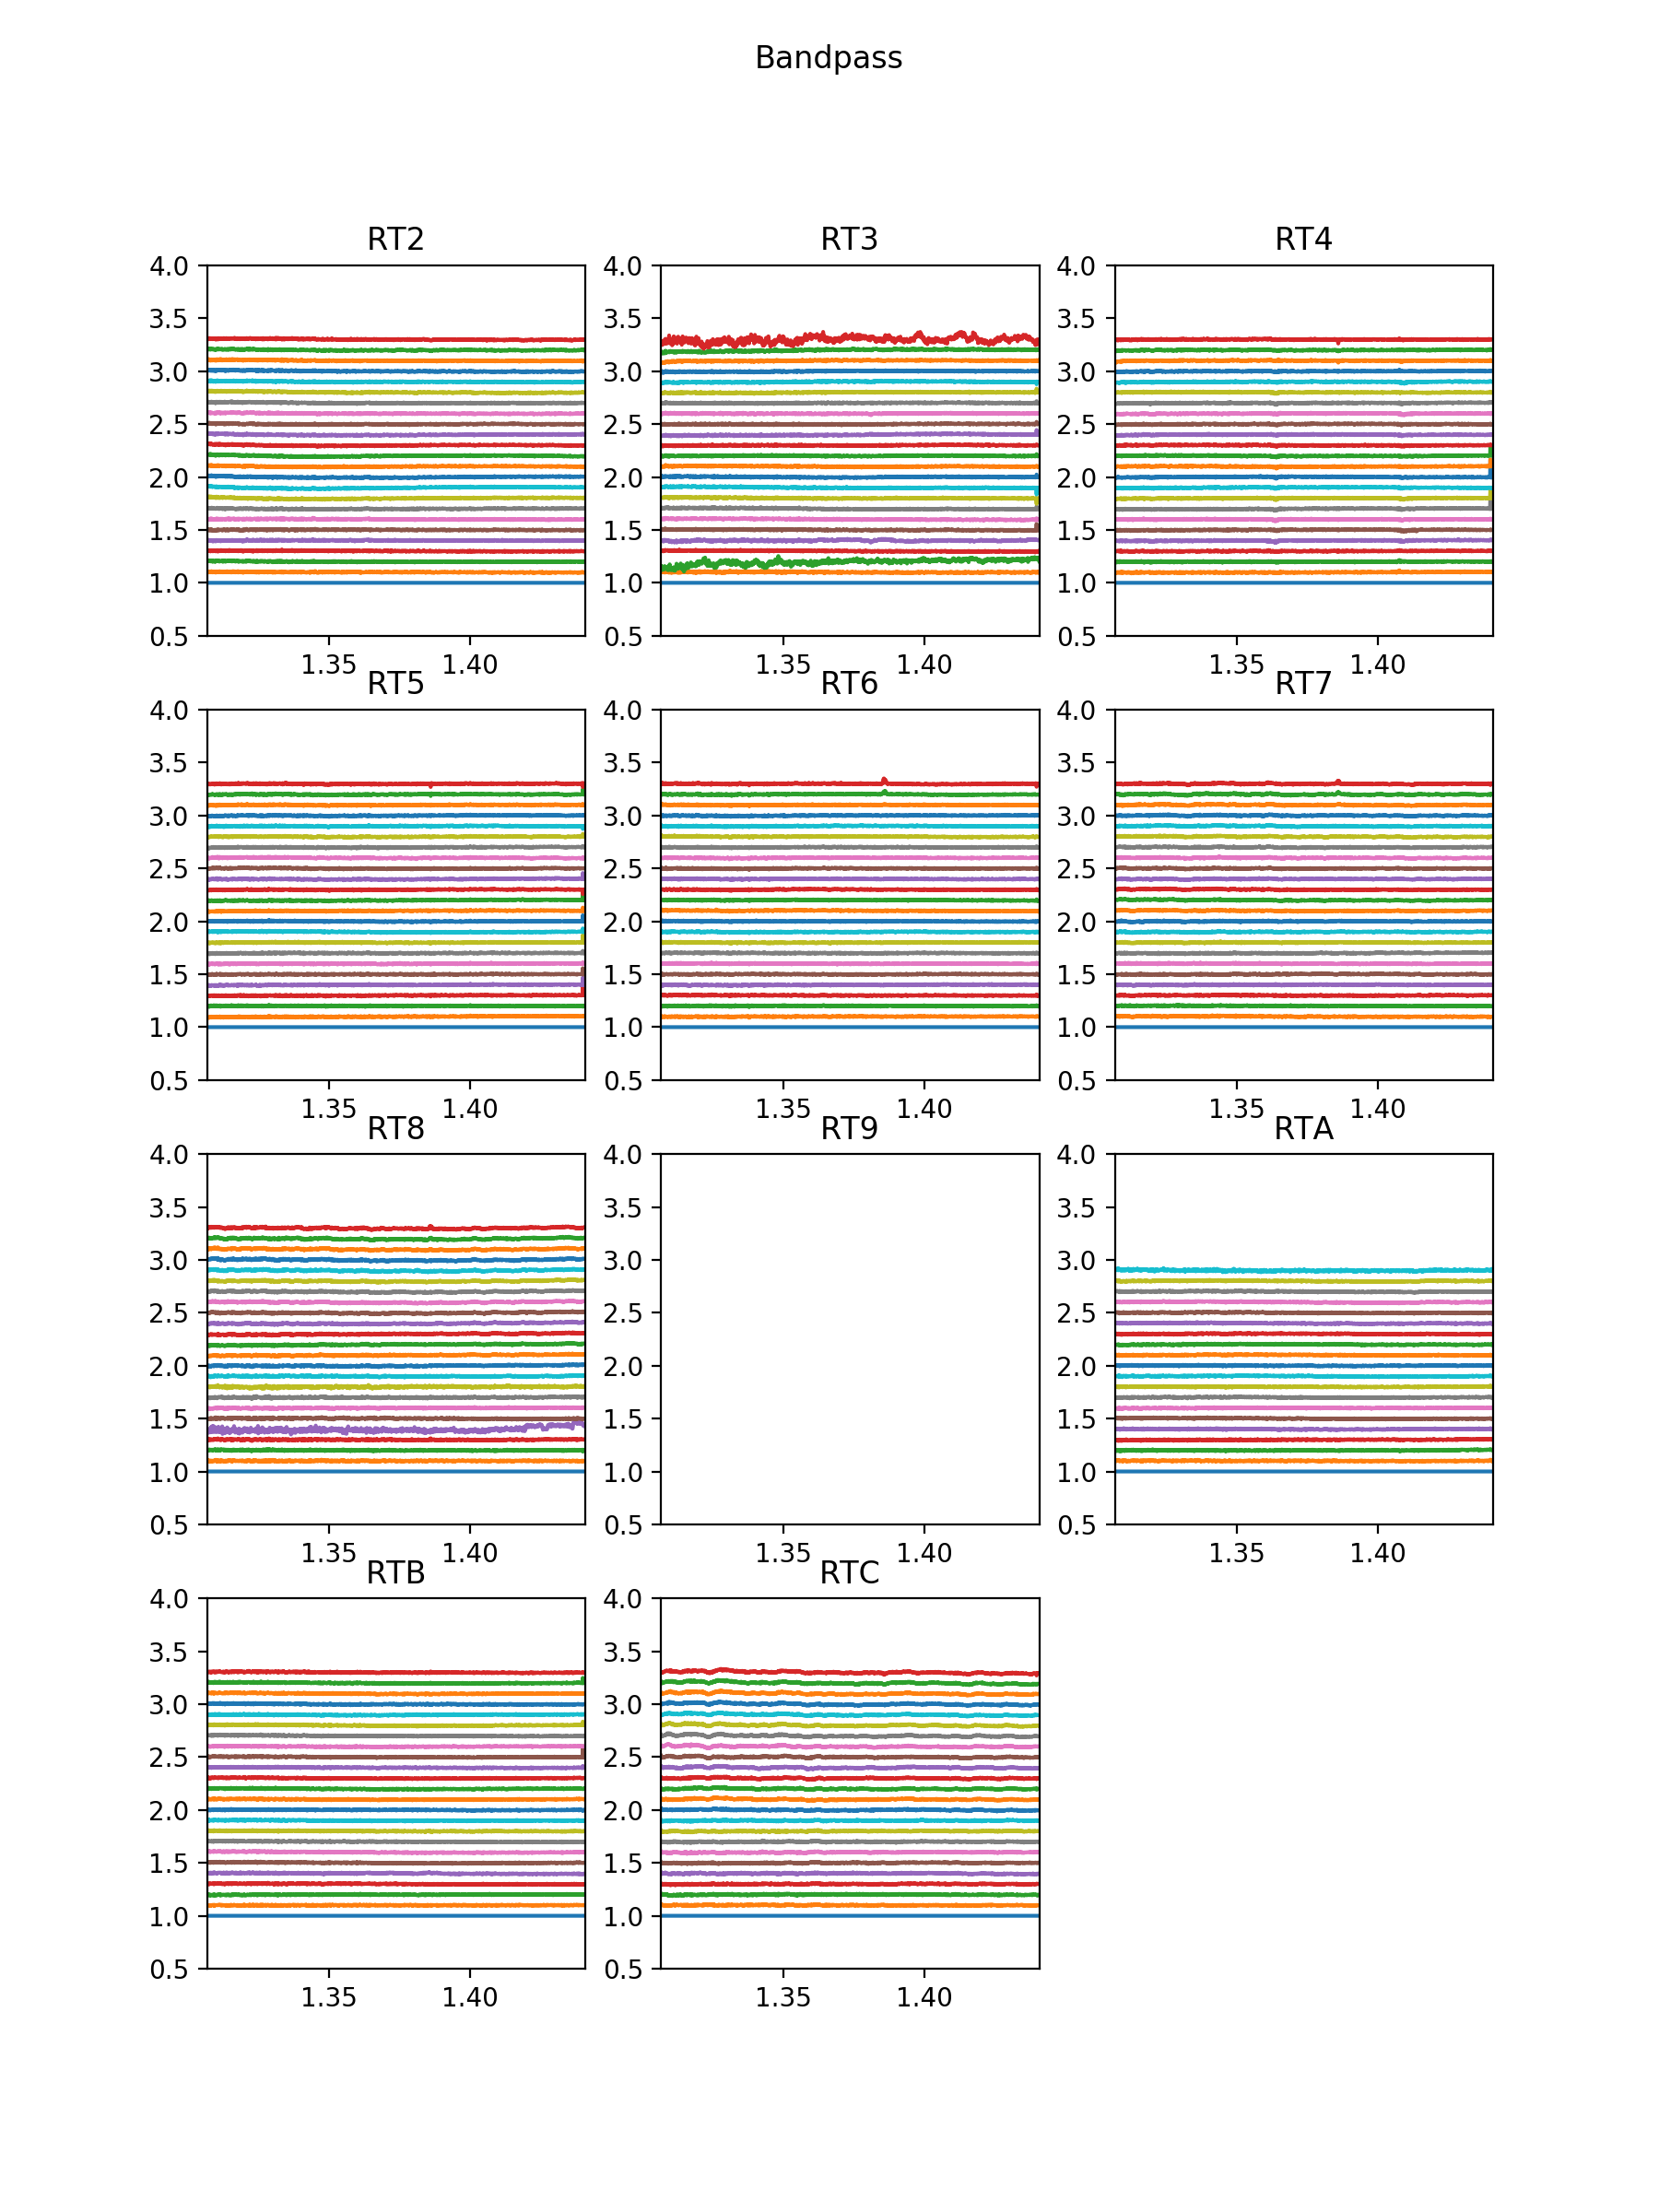

In [11]:
#plot the normalized, offset bandpass solutions for each antenna
fig=bp.plot_bp_per_ant(values,freqs,tnames,nchan=8,nx=3,norm=True,normscan=0,offset=0.1,ymax=4,plotsize=3,ymin=0.5)

<IPython.core.display.Javascript object>


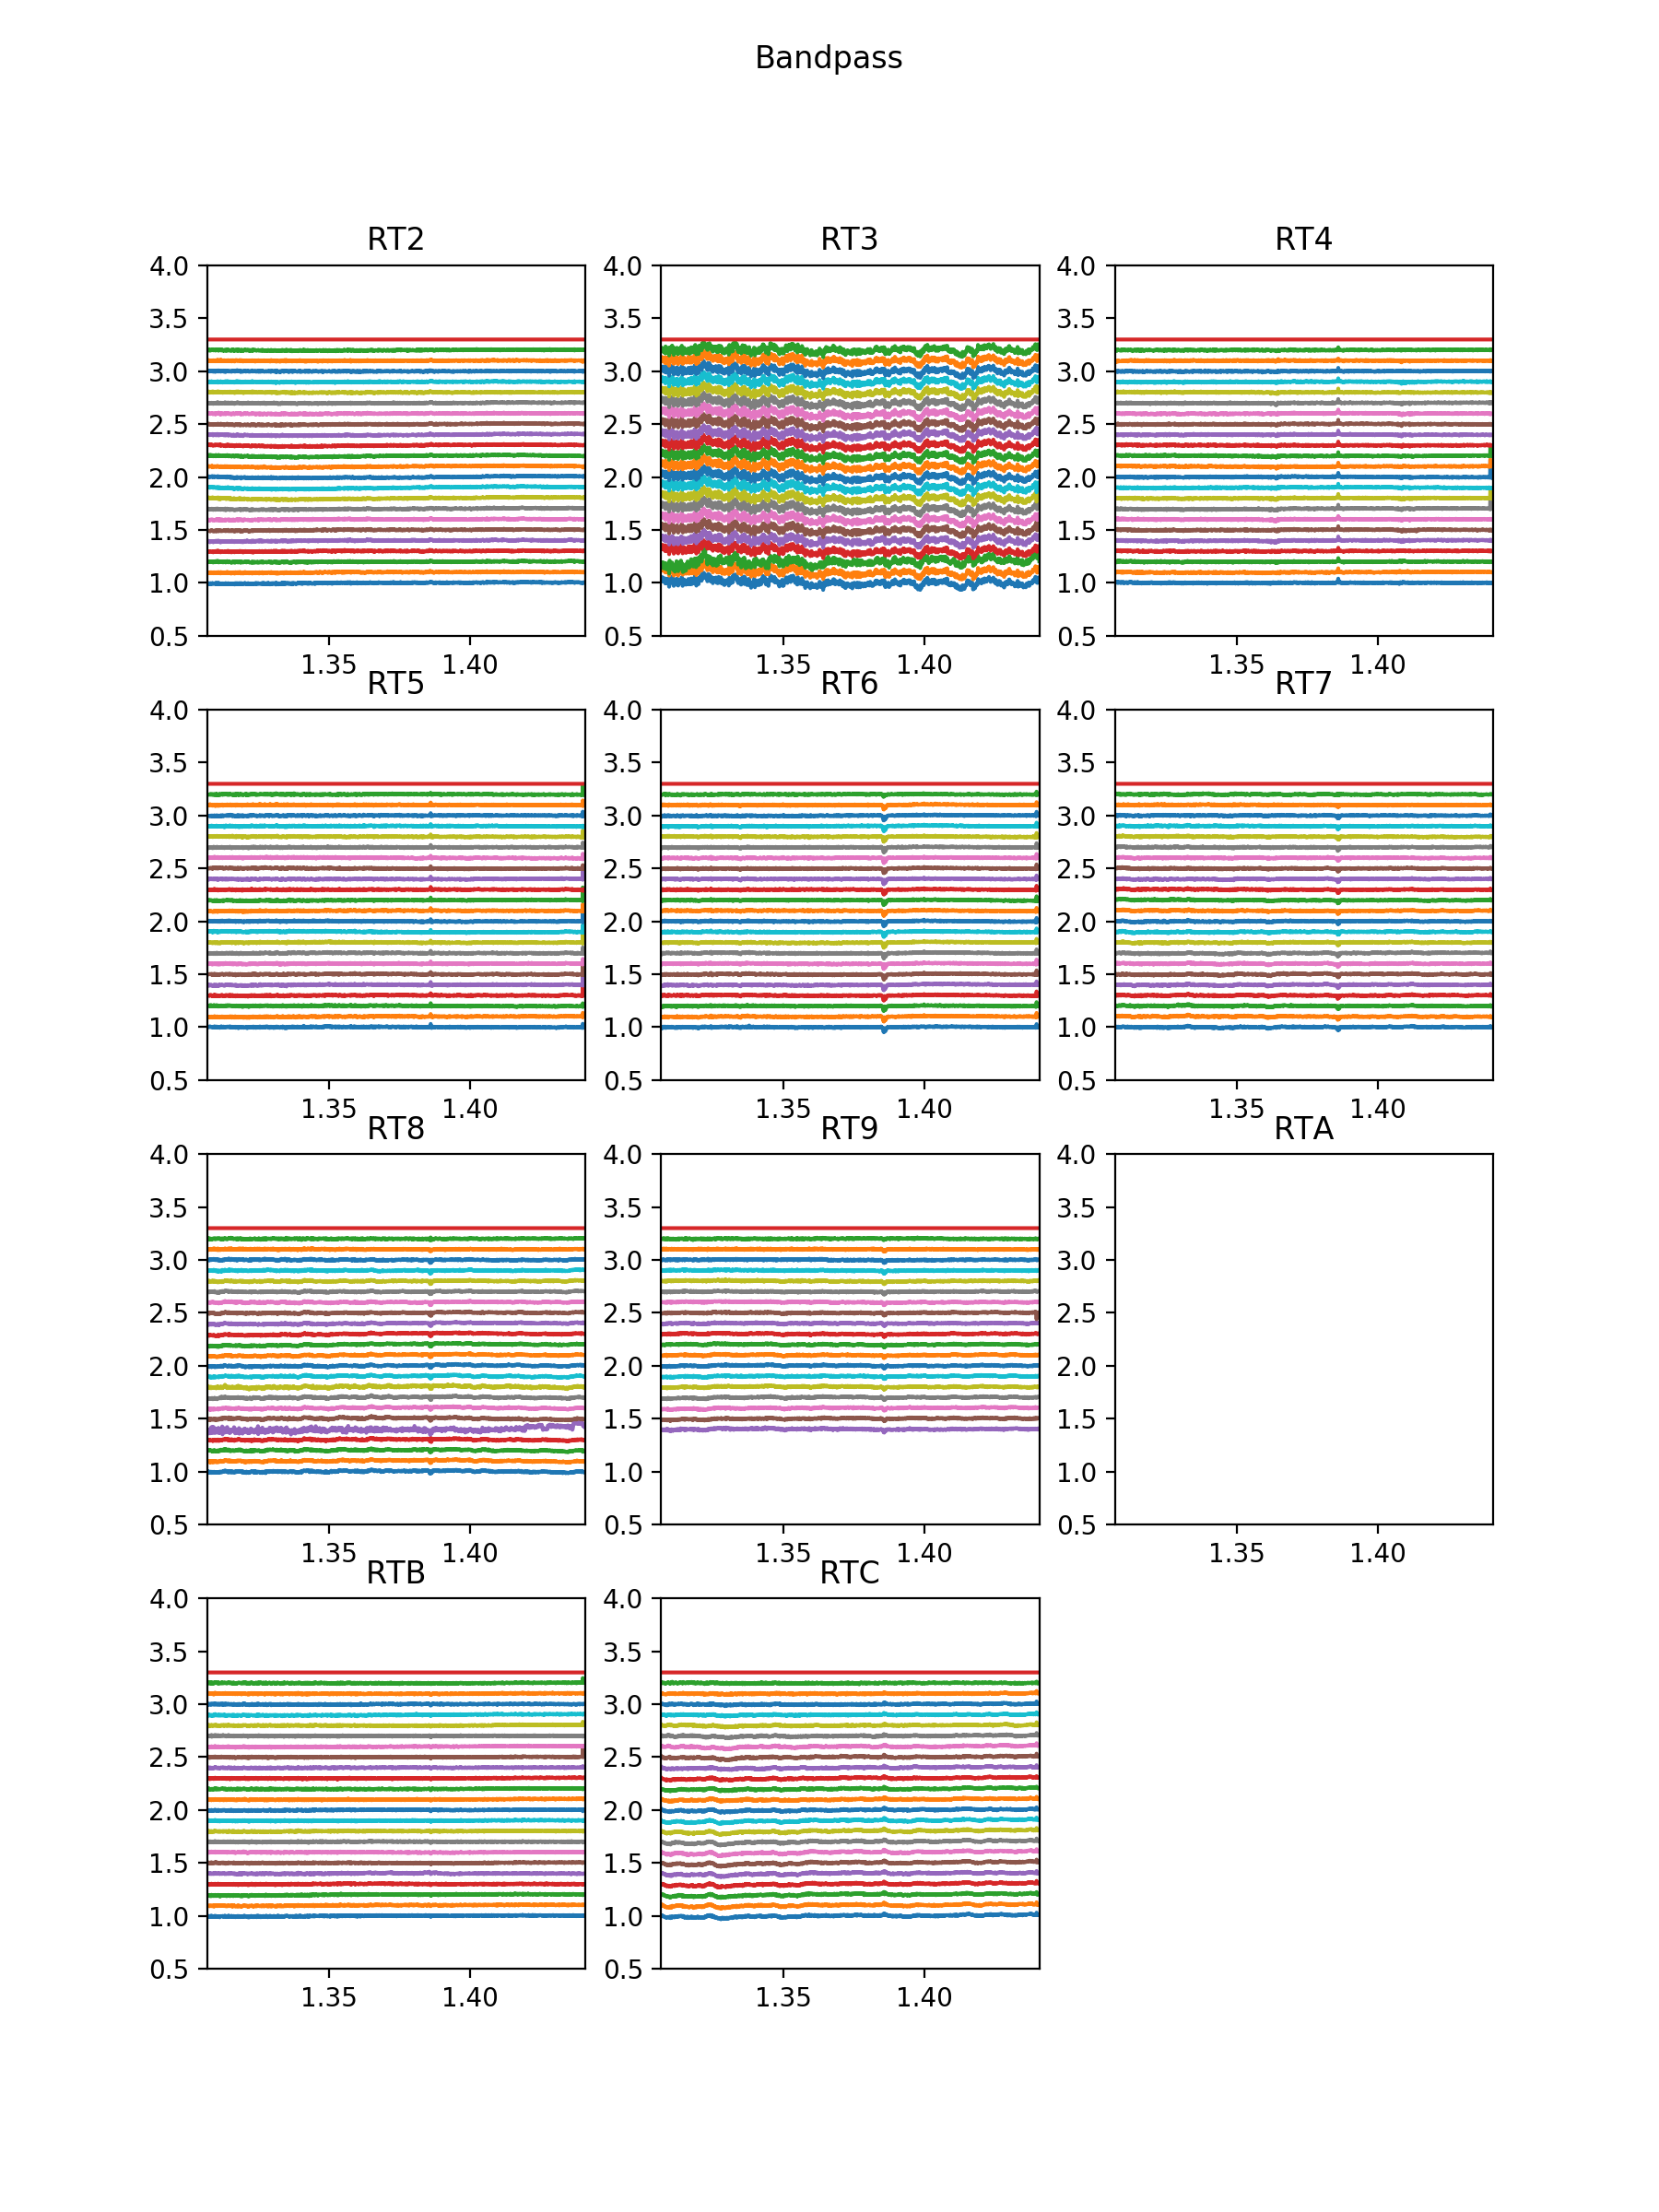

In [12]:
#plot the normalized, offset bandpass solutions for each antenna
#same as above, but now normalize to last scan
#note that a different antenna is lost
fig=bp.plot_bp_per_ant(values,freqs,tnames,nchan=8,nx=3,norm=True,normscan=-1,offset=0.1,ymax=4,plotsize=3,ymin=0.5)

/home/adams/python/bp.py:58: RuntimeWarning: Mean of empty slice
  avmean = np.nanmean(avvalues,axis=2)


<IPython.core.display.Javascript object>


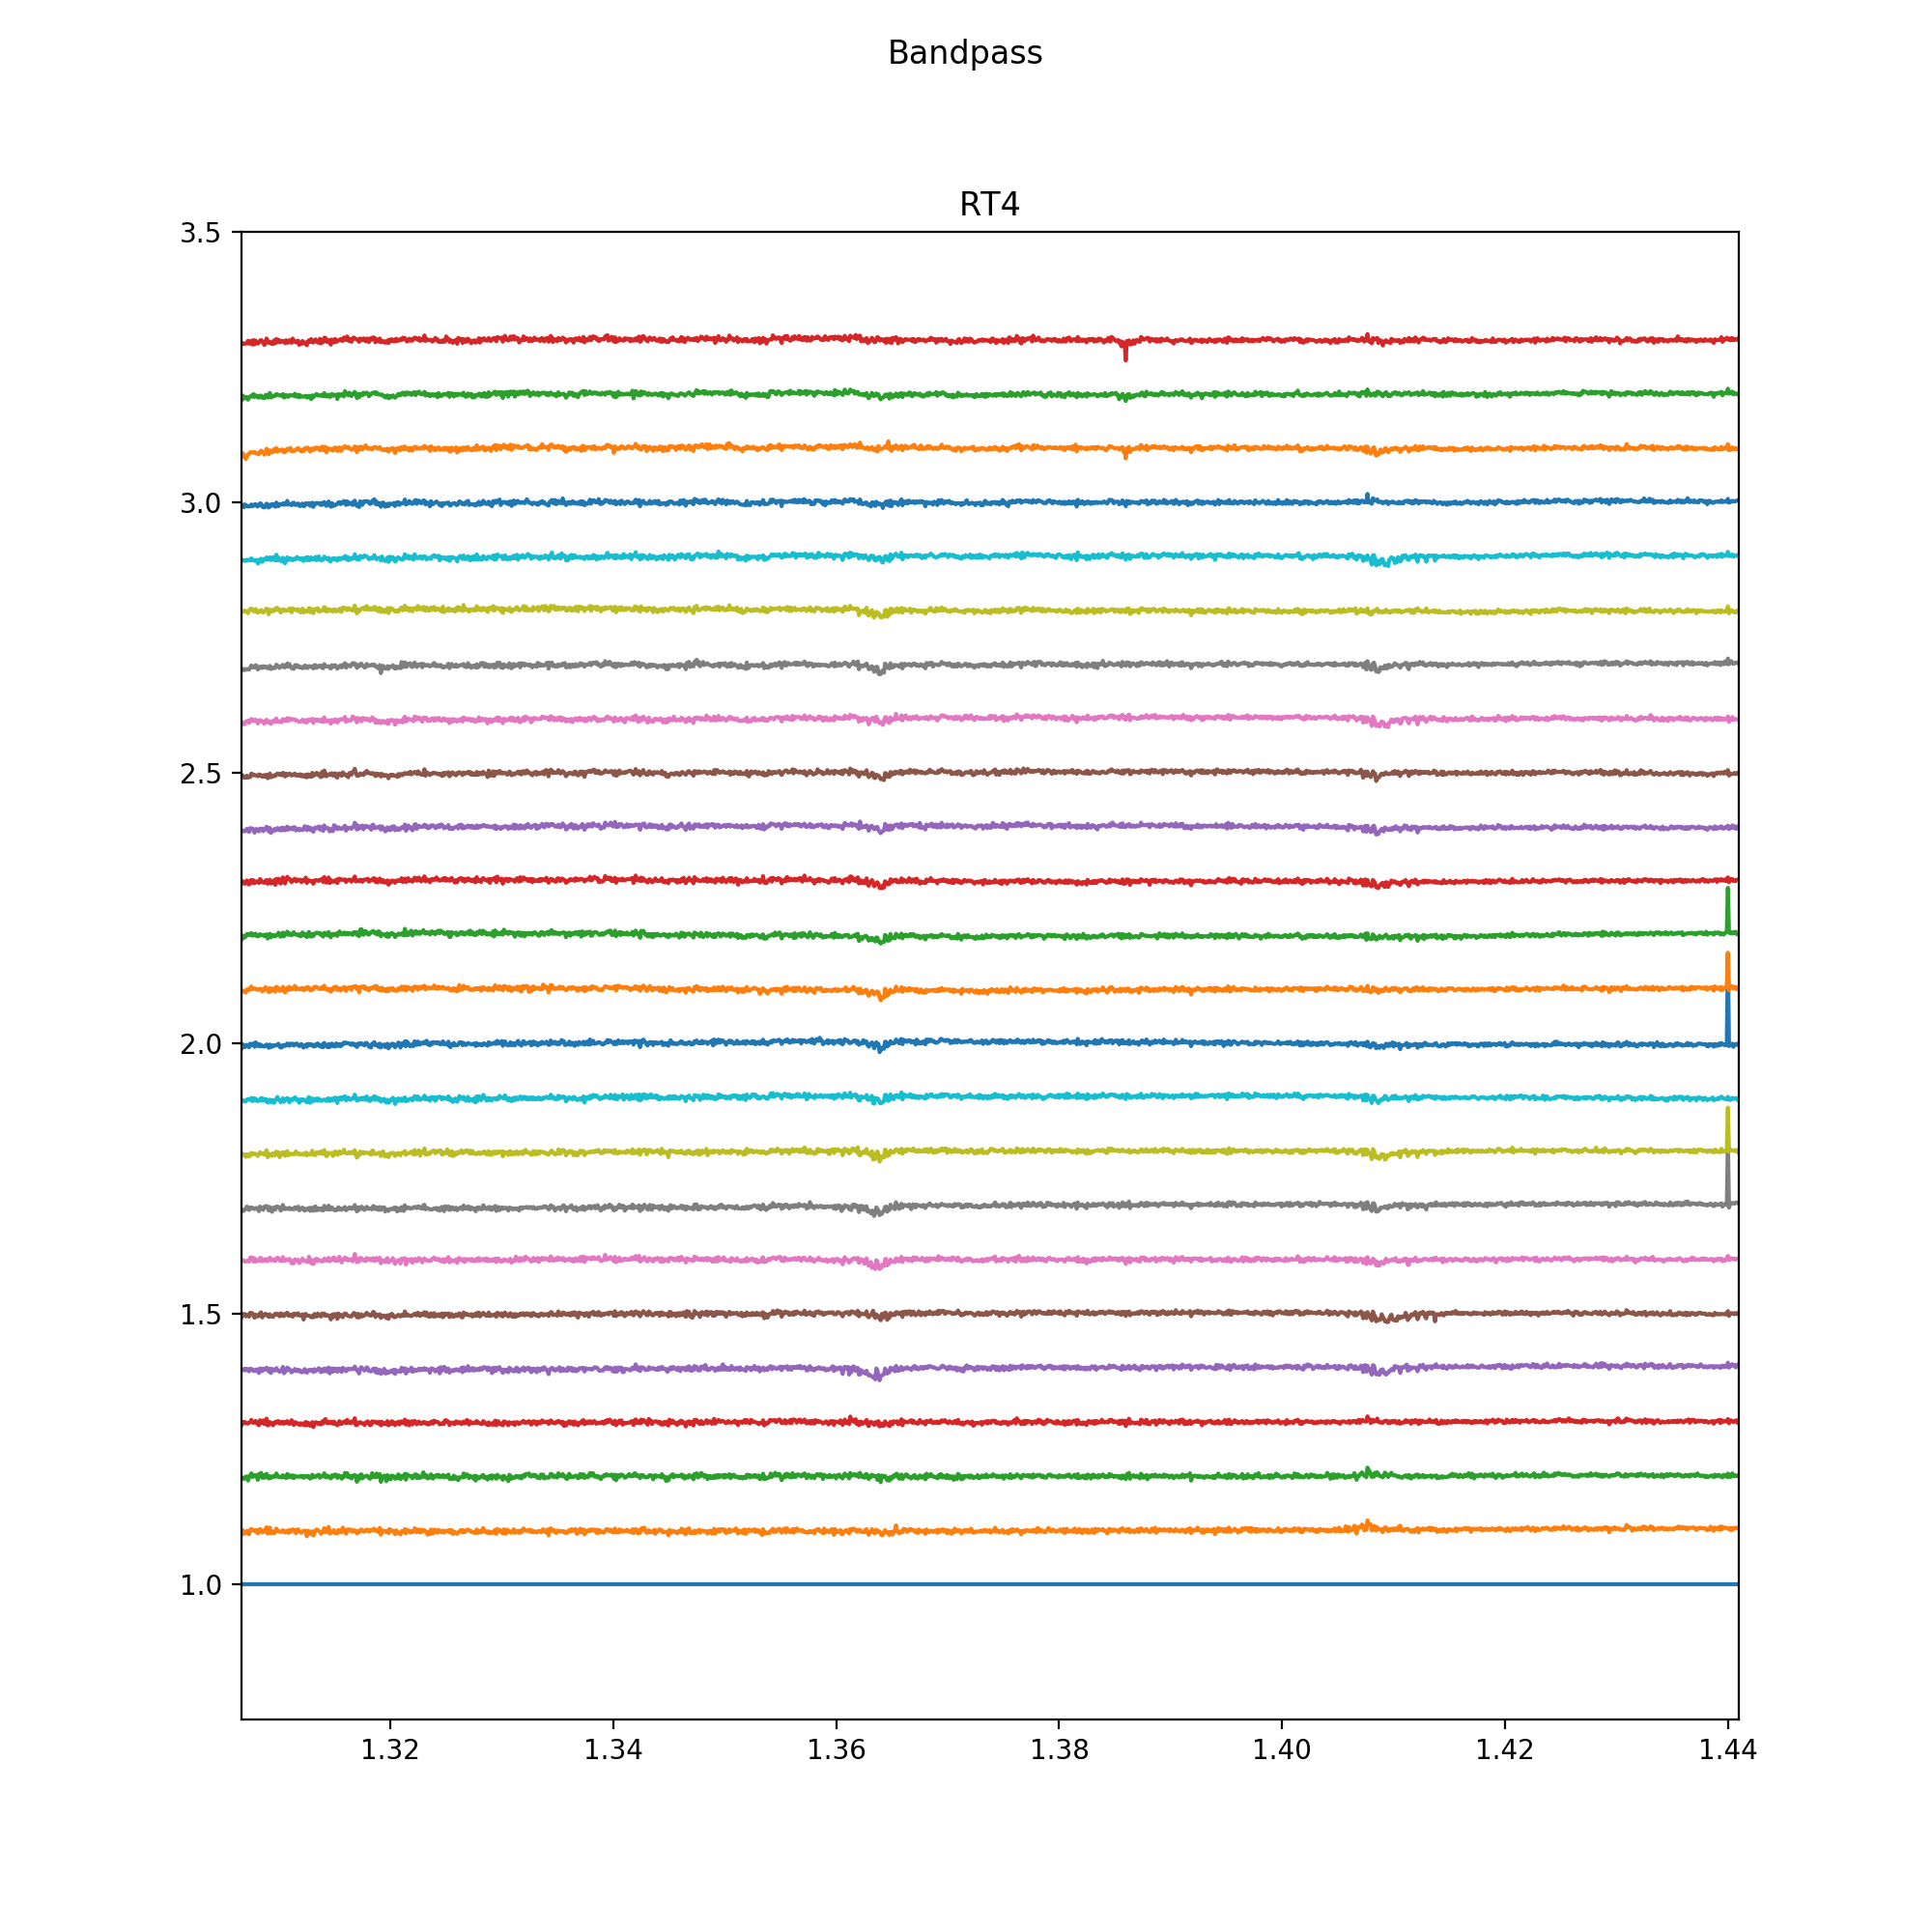

In [5]:
fig=bp.plot_bp_one_ant(values,freqs,2,'RT4',nchan=8,norm=True,normscan=0,offset=0.1,ymin=0.75,ymax=3.5,plotsize=10)

<IPython.core.display.Javascript object>


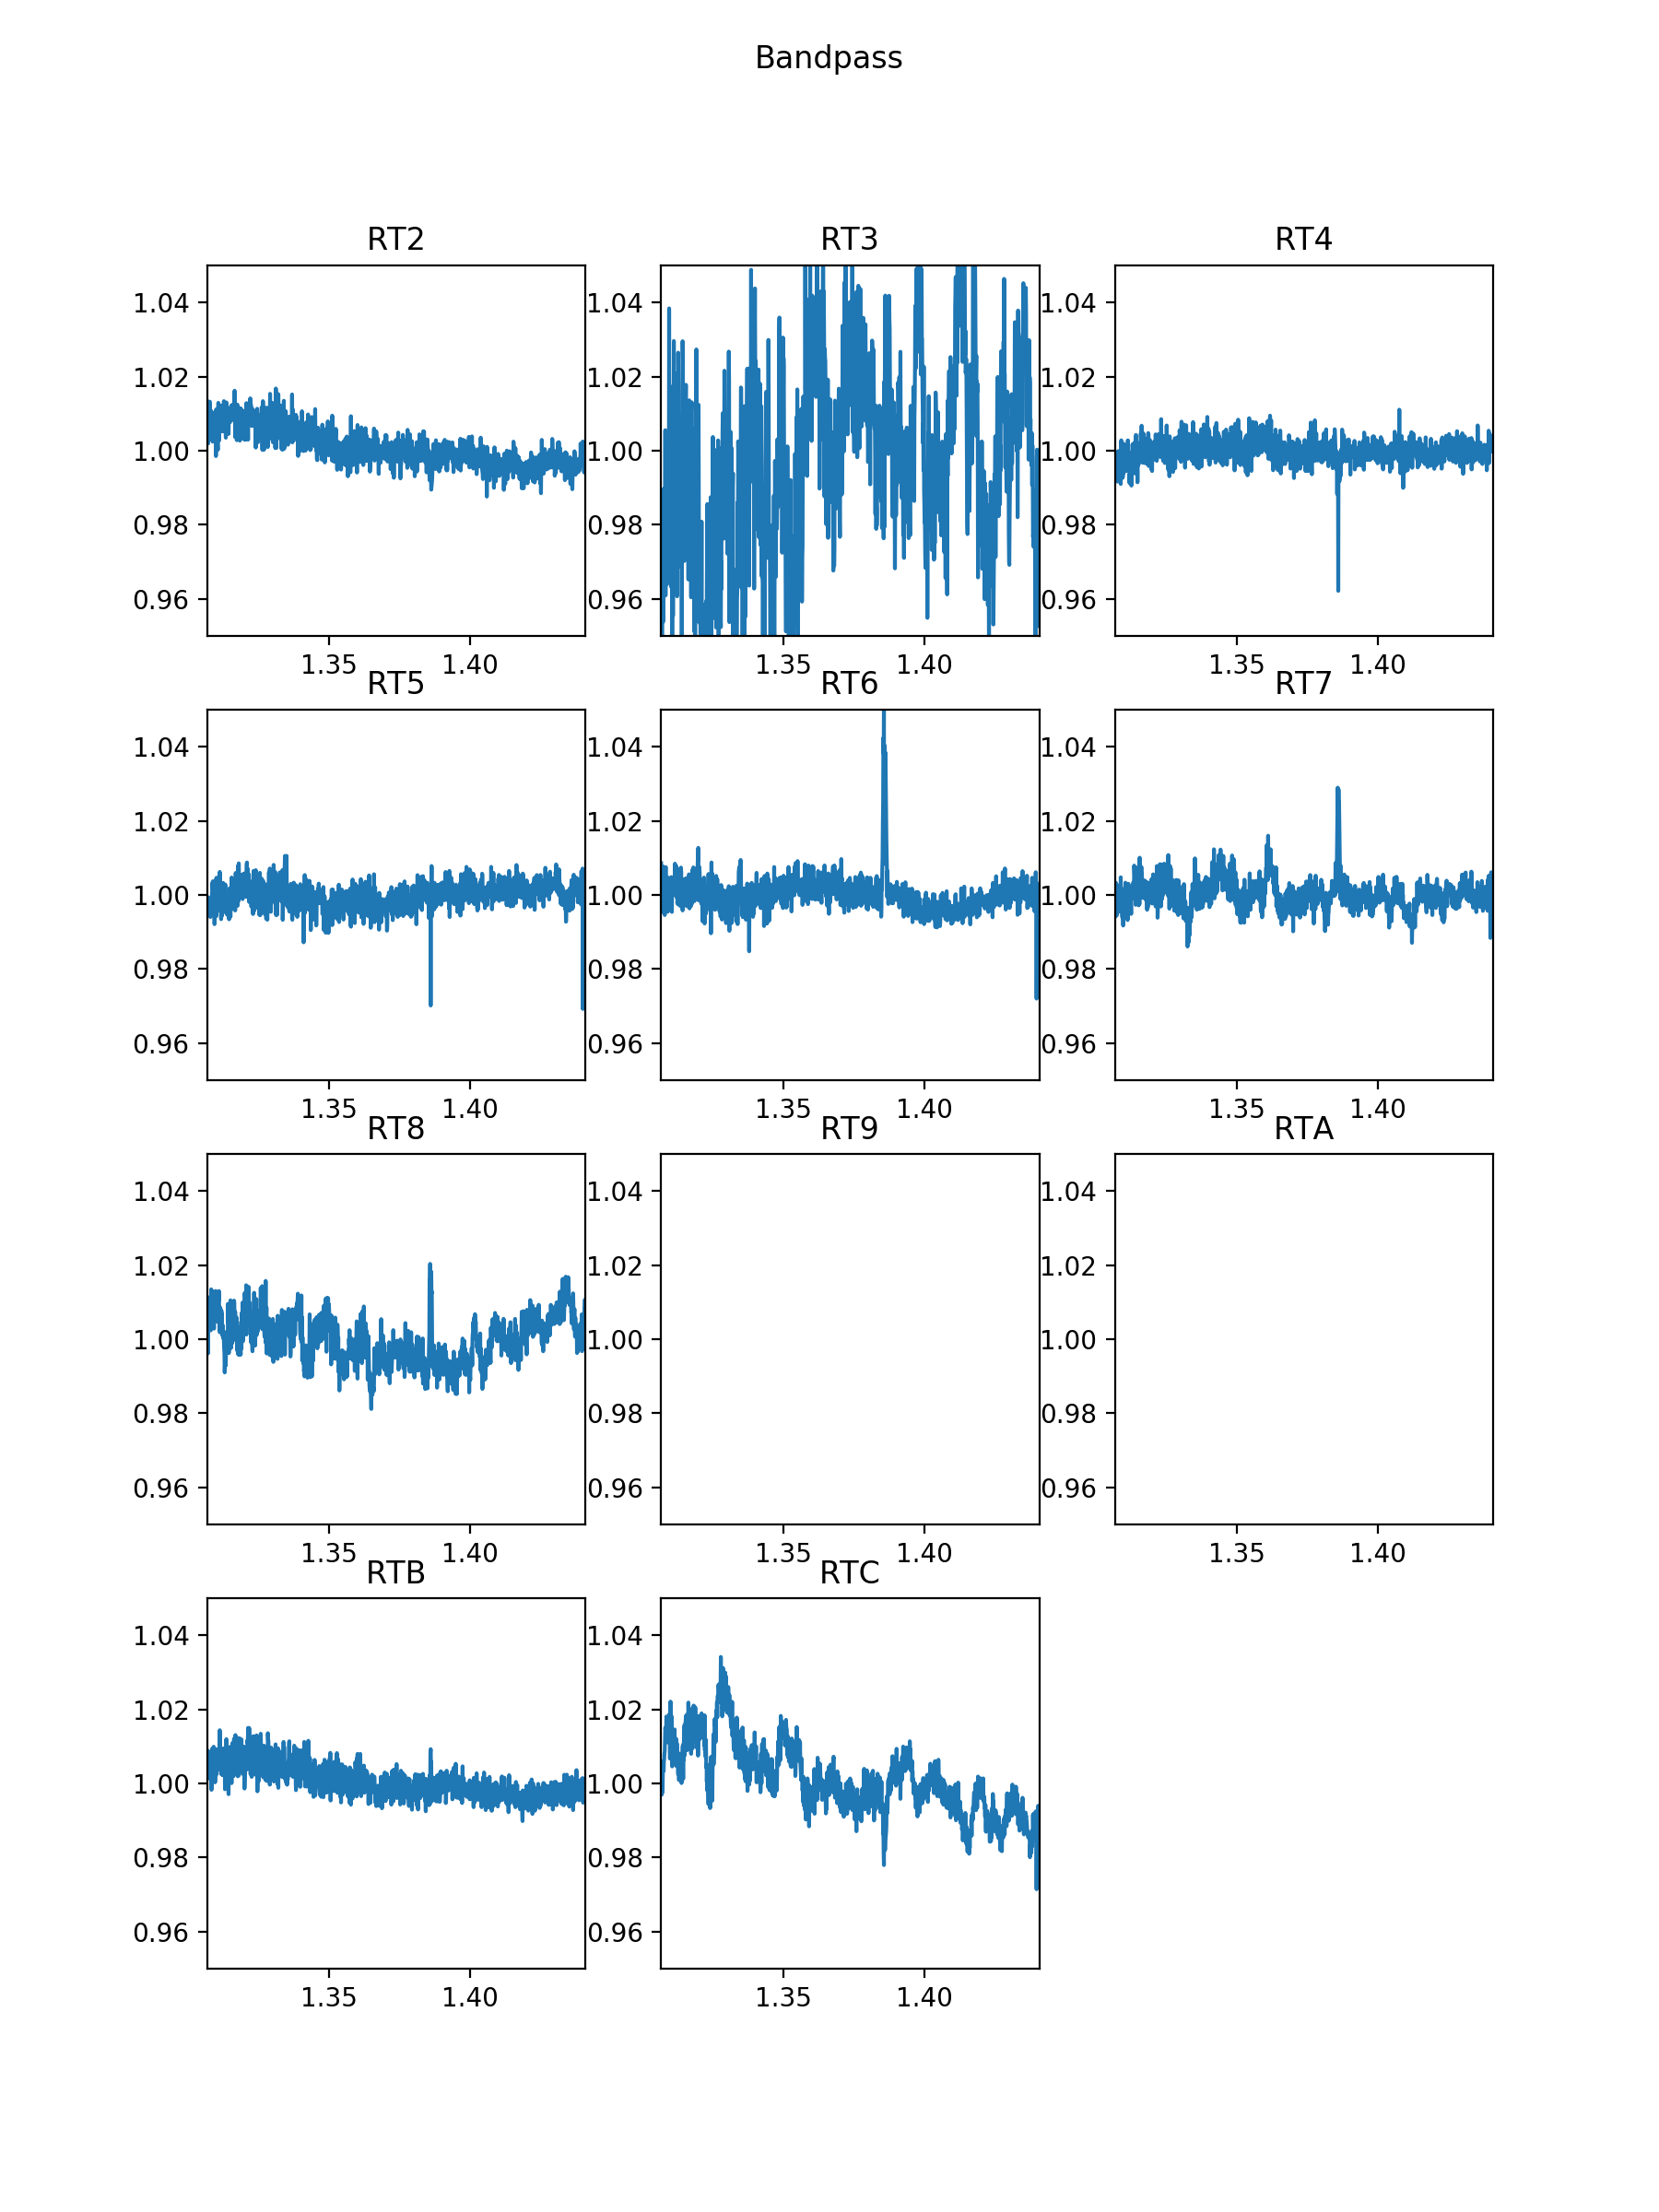

<IPython.core.display.Javascript object>


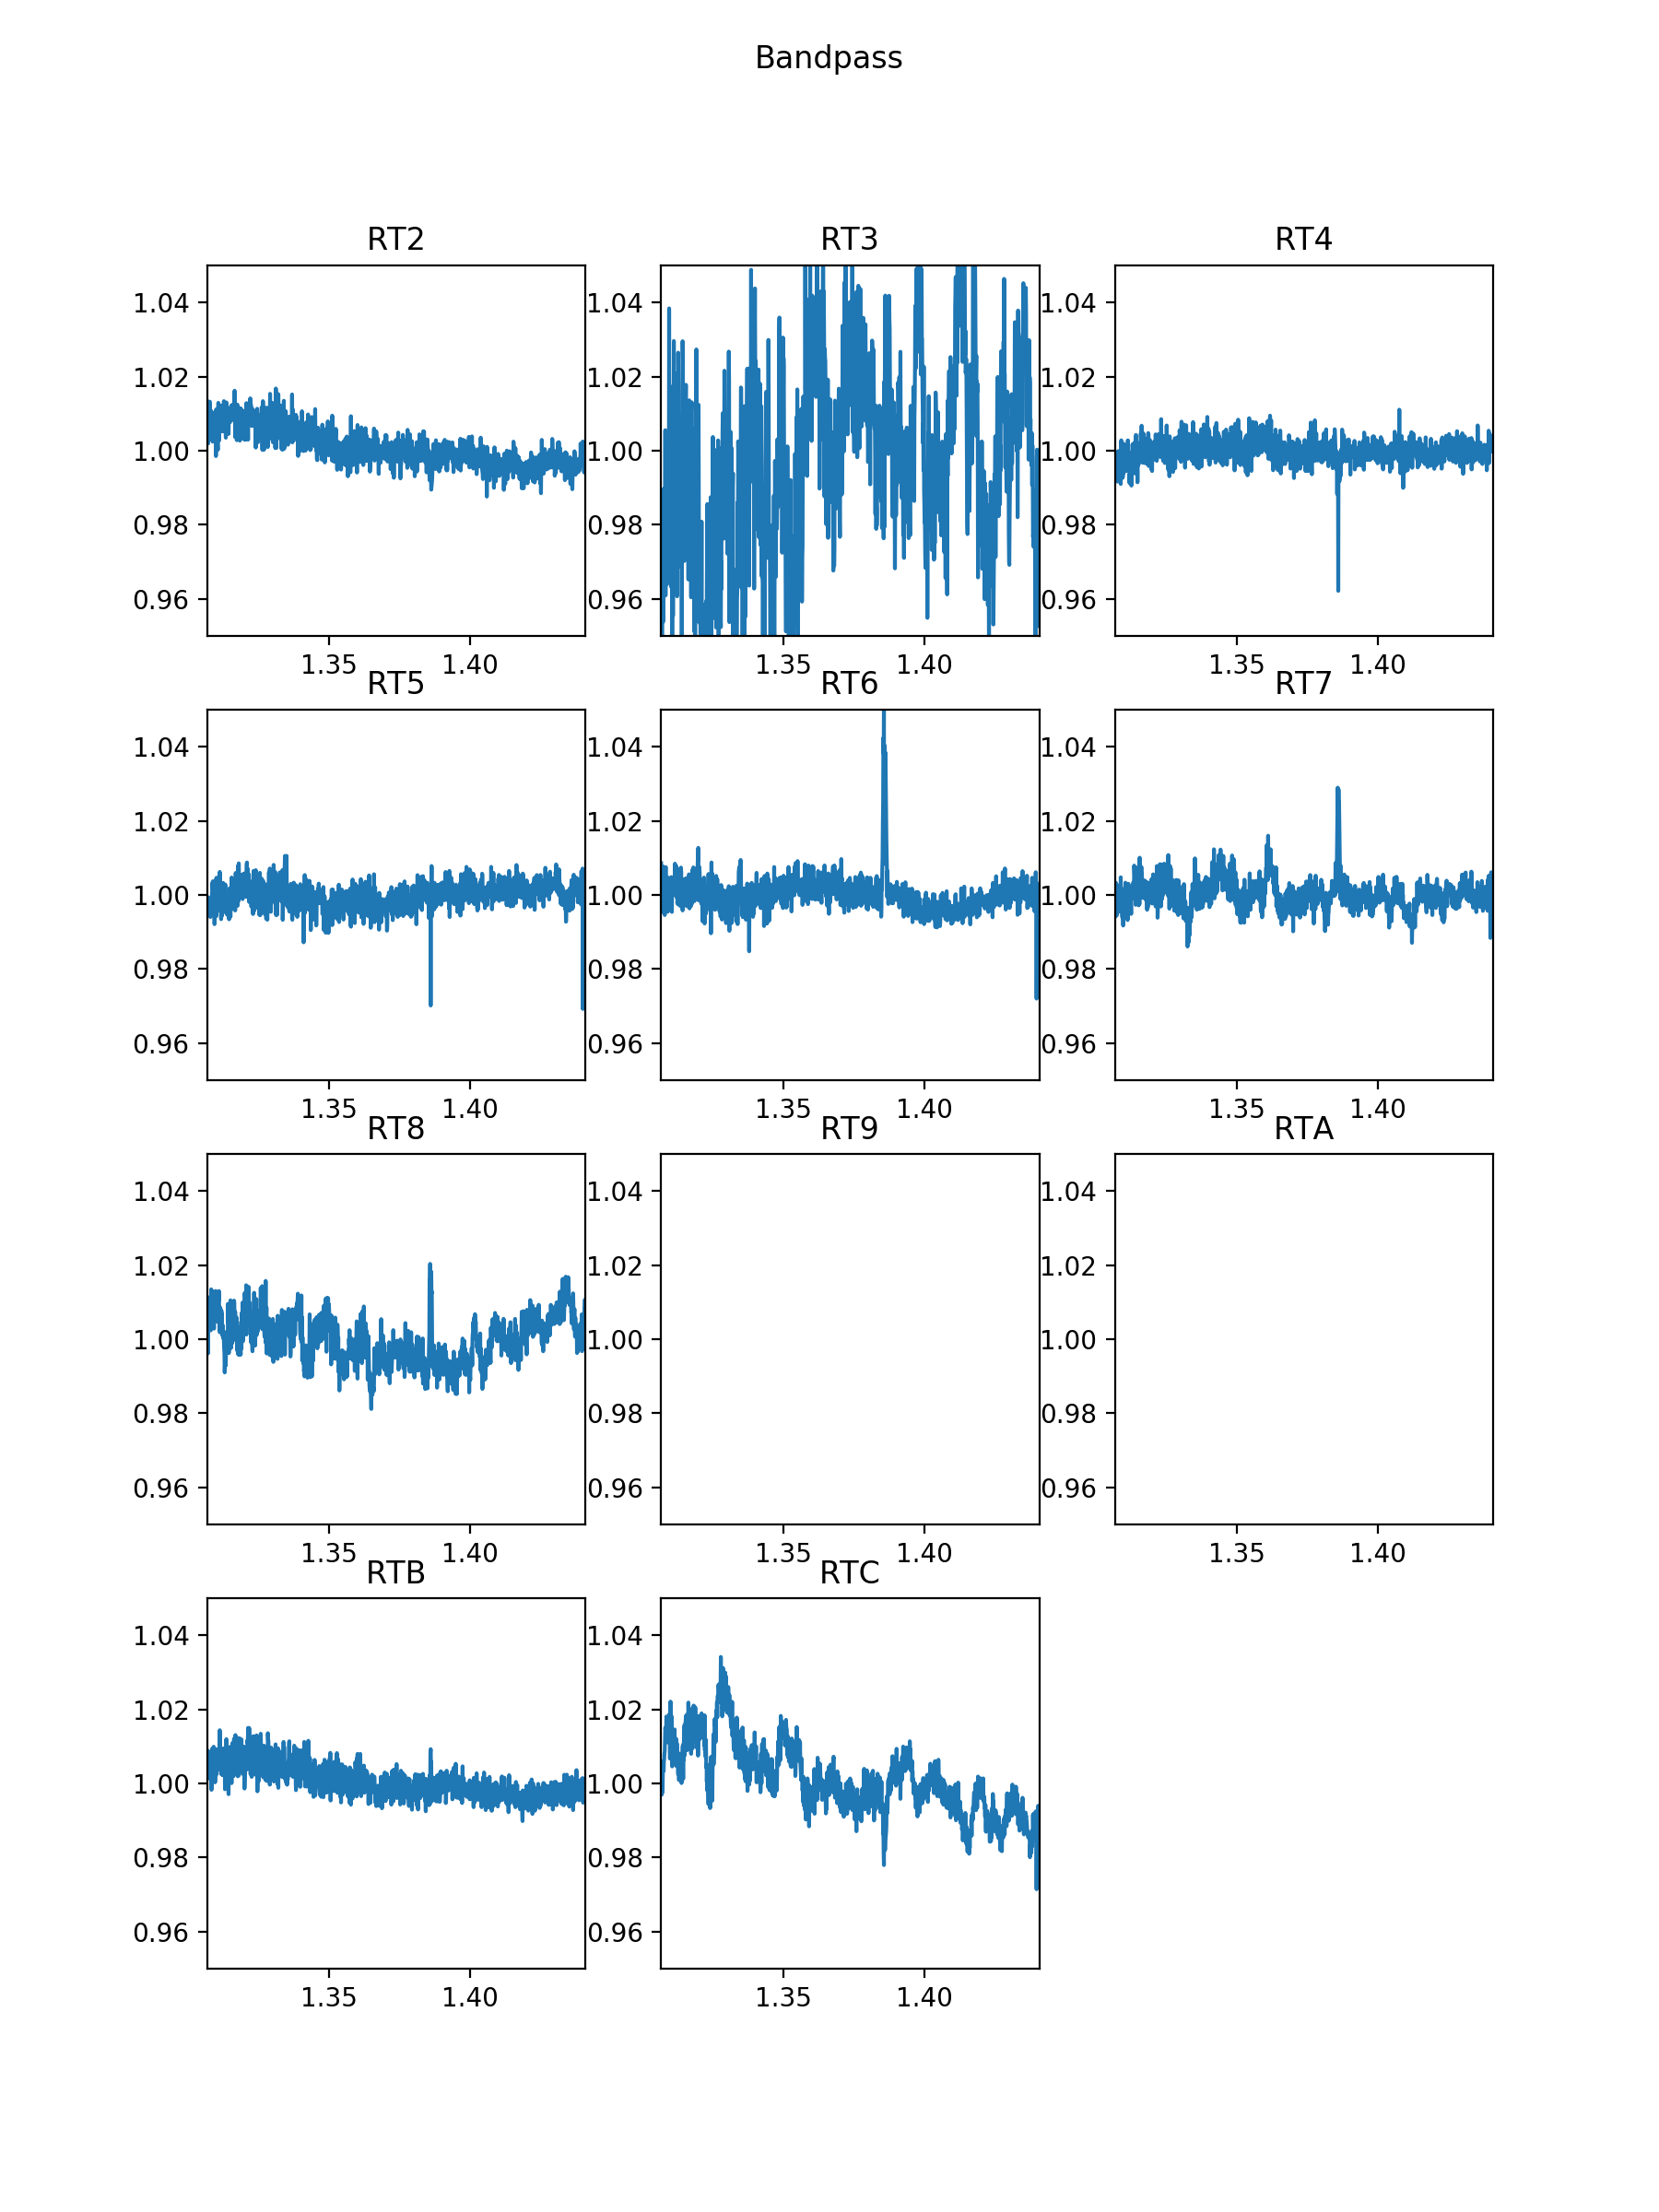

In [6]:
bp.plot_last_bp_per_ant(values,freqs,tnames,nchan=8,nx=3,ymin=0.95,ymax=1.05,plotsize=3)

Above are nice plots, but now we want to actually address the question of if we are meeting the science requirements. The requirements state that during a 12hr measurement the bandpass variation is less than 1:10^4 over a spectral range of 10 MHz. 

The question is now:<br>
What's the best way to address this?
<br>
<br>
We can first try smoothing to 10 MHz and calculating the deviation of each solution interval from a reference solution interval. However, this measure will be sensitive to variations larger than 10MHz which may be scientifically acceptable

In [ ]:
## Set the parameters for the bandpass calibration
gainint = '60' # Solution interval for calibrator gains
gapint = '60' # Maximum time gap in data until a new solution interval starts
bpint = '60' # Solution interval for the bandpass

# Execute the bandpass calibration
mfcal = lib.miriad('mfcal')
mfcal.vis = ccal.fluxcal
print mfcal.vis
# Comment the next line out if you don't want to solve for delays
mfcal.options = 'delay'
mfcal.stokes = 'XX'
mfcal.interval = gainint + ',' + gapint + ',' + bpint
mfcal.tol = 0.1 # Set the tolerance a bit lower. Otherwise mfcal takes a long time to finsh
#mfcal.go()

In [ ]:
import subs.readmirlog
values, freqs = subs.readmirlog.get_bp(ccal.crosscaldir + '/' + ccal.fluxcal)
# The bandpass results are ordered in a 3D numpy array called values in the following order: antenna, frequency, solution interval
# freqs gives you a list of the frequencies

In [ ]:
# You can plot all solution intervals for each antenna in one subplot each
from matplotlib import pyplot as plt
import numpy as np
values[values==0] = np.nan # Replace all zeros with nan
plt.figure(figsize=(13,8))
plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum frequencies
plt.suptitle('Bandpass', fontsize='large')

# Define an array with the telescope names
tnames = ['RT2','RT3','RT4','RT5','RT6','RT7','RT8','RT9','RTA','RTB']

for a in range(len(values[:])):
    plt.subplot(np.ceil(len(tnames)/4.0), 4, a+1)
    plt.plot(freqs, values[a,:,:])
    plt.title(tnames[a])
    plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum frequencies
    plt.ylim(np.nanmin(values), np.nanmax(values))
    plt.show()

In [ ]:
# The bandpass might be better visualised by averaging over each subband of 64 channels

values[values==0] = np.nan # Replace all zeros with nan
avvalues = values.reshape(values.shape[0],-1, 64,values.shape[2]) # Reshape the second axis of the array
avmean = np.nanmean(avvalues, axis=2) # Calculate the mean over the new axis
avfreqs = np.nanmean(freqs.reshape(-1,64), axis=1) # Adjust the size of the freqeucny axis to the new shape

# Now create the same plot as above
plt.figure(figsize=(13,8))
plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum frequencies
plt.suptitle('Bandpass averaged over 64 channels (1 subband)', fontsize='large')

for a in range(len(avvalues[:])):
    plt.subplot(np.ceil(len(tnames)/4.0), 4, a+1)
    plt.plot(avfreqs, avmean[a,:,:])
    plt.title(tnames[a])
    plt.xlim(np.min(avfreqs),np.max(avfreqs)) # Limit the plot to the minimum and maximum frequencies
    plt.ylim(np.nanmin(avvalues), np.nanmax(avvalues))
    plt.show()

In [ ]:
# Let's fit a polynomial to the bandpass using the average of all solution intervals
polyorder = 3 # Order of the fitted polynomial
for a in range(len(tnames)):
    fitvalues = np.poly1d(np.polyfit(avfreqs, np.nanmean(avmean[a], axis=1), deg=polyorder)) # Fit a polynomial to all telescopes at once
    print(tnames[a])
    print(fitvalues)

In [ ]:
# Plot the bandpass plus the fitted solutions

# Fill the fit with values to plot
xp = np.linspace(np.min(freqs),np.max(freqs),len(avfreqs))

plt.figure(figsize=(13,8))
plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum frequencies
plt.suptitle('Bandpass averaged over 64 channels (1 subband) and polynomial ' + str(polyorder) + ' order fit', fontsize='large')

for a in range(len(avvalues[:])):
    plt.subplot(np.ceil(len(tnames)/4.0), 4, a+1)
    plt.plot(avfreqs, avmean[a,:,:])
    plt.plot(avfreqs, fitvalues(avfreqs),'--',c='r')
    plt.title(tnames[a])
    plt.xlim(np.min(avfreqs),np.max(avfreqs)) # Limit the plot to the minimum and maximum frequencies
    plt.ylim(np.nanmin(avvalues), np.nanmax(avvalues))
    plt.show()

In [ ]:
# Divide all solutions by the first solution interval to normalise
div = np.dstack([values[:,:,0]] * len(values[0,0]))
normvalues = values/div
# Then show the solutions for all solution intervals of one antenna
antenna = 'RT8' # You can change this one as you want
t = tnames.index(antenna)
plt.figure(figsize=(13,8))
plt.suptitle('Normalised bandpass solutions for antenna ' + antenna + ' and all solution intervals', fontsize='large')
for s in range(normvalues.shape[-1]):
    plt.subplot(np.ceil(normvalues.shape[-1]/4.0), 4, s+1)
    plt.scatter(freqs, normvalues[t,:,s],marker='.')
    plt.title('Interval ' + str(s))
    plt.xlim(np.min(freqs),np.max(freqs)) # Limit the plot to the minimum and maximum freqeuncies
    plt.ylim(np.nanmin(normvalues),np.nanmax(normvalues))
    plt.show()

In [ ]:
# Calculate the average over the frequency axis for each antenna and solution interval and visualise it in a plot
antaver = np.nanmean(normvalues,axis=1)
plt.figure(figsize=(13,8))
plt.suptitle('Average Bandpass for each solution interval and antenna', fontsize='large')
plt.imshow(antaver, interpolation='none')
plt.xlabel('Solution number')
plt.ylabel('Antenna')
plt.colorbar(label='Average Amplitude Solution')
plt.gca().set_yticks(range(len(tnames)))
plt.gca().set_yticklabels(tnames)
plt.show()

In [ ]:
# Calculate the standard deviation over the freqeucny axis for each antenna and solution interval and visualise it in a plot
antstd = np.nanstd(normvalues,axis=1)
plt.figure(figsize=(13,8))
plt.suptitle('Average Standard Deviation of the normalised bandpass for each solution interval and antenna', fontsize='large')
plt.imshow(antstd, interpolation='none')
plt.xlabel('Solution number')
plt.ylabel('Antenna')
plt.colorbar(label='Average Amplitude Standard Deviation')
plt.gca().set_yticks(range(len(tnames)))
plt.gca().set_yticklabels(tnames)
plt.show()

In [ ]:
# If we exclude the first solution interval (it is the one we normalised with) and the last one (it is not a full one) we can make a plot with more contrast
antstd_noflsol = np.nanstd(normvalues[:,:,1:values.shape[-1]-1],axis=1)
plt.figure(figsize=(13,8))
plt.suptitle('Same as above except excluding the first and last solution interval', fontsize='large')
plt.imshow(antstd_noflsol, interpolation='none')
plt.xlabel('Solution number')
plt.ylabel('Antenna')
plt.colorbar(label='Average Amplitude Standard Deviation')
plt.gca().set_yticks(range(len(tnames)))
plt.gca().set_yticklabels(tnames)
plt.show()

In [ ]:
#I wanted to see what I think about my idea of a 2-D plot of time freuency offsets

diff = np.dstack([normvalues[:,:,0]] * len(values[0,0]))

diffvalues = normvalues - diff

#I also want to average these values to subband width (or could be something else)
avdiffvalues = diffvalues.reshape(diffvalues.shape[0],-1, 64,diffvalues.shape[2]) # Reshape the second axis of the array
avdiffmean = np.nanmean(avdiffvalues, axis=2) # Calculate the mean over the new axis
#avfreqs = np.nanmean(freqs.reshape(-1,64), axis=1) # Adjust the size of the freqeucny axis to the new shape
"""Does the frequnecy reshaping actually work properly, i.e, get middle value of freq?"""

print diffvalues.shape,avdiffvalues.shape, avdiffmean.shape, avfreqs.shape

antenna = 'RT8' # You can change this one as you want
t = tnames.index(antenna)
plt.figure(figsize=(13,8))
plt.suptitle('Relative offset for ' + antenna + ' and all solution intervals', fontsize='large')
for s in range(avdiffmean.shape[-1]):
    plt.subplot(np.ceil(avdiffmean.shape[-1]/4.0), 4, s+1)
    plt.scatter(avfreqs, avdiffmean[t,:,s],marker='.')
    plt.title('Interval ' + str(s))
    plt.xlim(np.min(avfreqs),np.max(avfreqs)) # Limit the plot to the minimum and maximum freqeuncies
    plt.ylim(np.nanmin(avdiffmean),np.nanmax(avdiffmean))
    plt.show()

In [ ]:
#now try to make a 2D plot
#want a plot for each antenna, frequency vs time
#use same syntax as Bjorn for iterating on plots

plt.figure(figsize=(13,8))

for a in range(len(avvalues[:])):
    plt.subplot(np.ceil(len(tnames)/4.0), 4, a+1)
    #plt.plot(avfreqs, avdiffmean[a,:,:])
    plt.imshow(np.transpose(avdiffmean[a,:,:]),aspect='auto', interpolation='none')
    #avdiffmean[t,:,s]
    #plt.plot(avfreqs, fitvalues(avfreqs),'--',c='r')
    plt.title(tnames[a])
    #plt.xlim(np.min(avfreqs),np.max(avfreqs)) # Limit the plot to the minimum and maximum frequencies
    #plt.ylim(np.nanmin(avvalues), np.nanmax(avvalues))
    plt.xlabel('subband')
    plt.ylabel('solution interval')
    plt.show()
    


In [ ]:
nant=len(avvalues[:])

ny = 3
nx = int(np.ceil(nant/float(ny)))


xsize=nx*4.
ysize=ny*4.

print nant,nx,ny,xsize,ysize

fig, axarr=plt.subplots(ny,nx,figsize=(xsize,ysize),sharex=True,sharey=True)
for ant in xrange(nant):
    #but I have to get fancy because xarr has shape ny,nx
    col = np.mod(ant,ny)
    row = int(np.floor(ant/float(ny)))
    print ant,col,row
    axarr[row,col].imshow(avdiffmean[ant,:,:],aspect='equal')
    label='Antenna index '+str(ant)



    
fig.show()

In [ ]:
gains, times = subs.readmirlog.get_gains(ccal.crosscaldir + '/' + ccal.fluxcal)
print  times